In [8]:
import numpy as np
import healpy as hp
import pandas as pd
from Tgsm import*

import matplotlib.pyplot as plt
from matplotlib import cm
import copy

Cmap = copy.copy(cm.get_cmap("jet"))
Cmap_mock = copy.copy(cm.get_cmap("plasma"))
Cmap.set_under("w")
Cmap_mock.set_under('w')
%matplotlib inline

In [9]:
# Path for image storage
impath = 'images/'

# Trajectory

We will compute the trajectory of a full dayof observation for SCI-HI, for the day 2018-06-14 at 00:00:00 until 2018-06-15 at 00:00:00.

For this we will generate an array of time and then use the trajectory function in Tgsm.py for this array. 

In [10]:
dates =  ['2018-06-14 00:00:00','2018-06-15 00:00:00']
T = Time(dates)
dt = T[1]-T[0]
times = T[0] + dt*np.linspace(0.,1.,300)

Text(0, 0.5, '$b$ [degrees]')

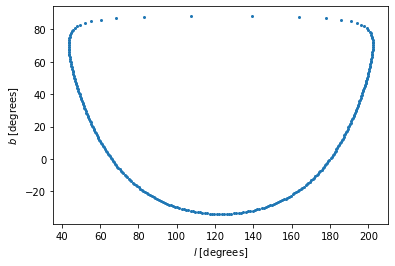

In [11]:
l_gal,b_gal = trajectory(times)
plt.plot(l_gal,b_gal,'o',markersize=2)
plt.xlabel(r'$l$ [degrees]')
plt.ylabel(r'$b$ [degrees]')
#plt.savefig(impath+'trayectory.png')

Visualization of the Galaxy in 70 MHz along with the trajectory previously calculated.

/home/missael/miniconda3/envs/universidad/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/home/missael/miniconda3/envs/universidad/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/home/missael/miniconda3/envs/universidad/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/home/missael/miniconda3/envs/universidad/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


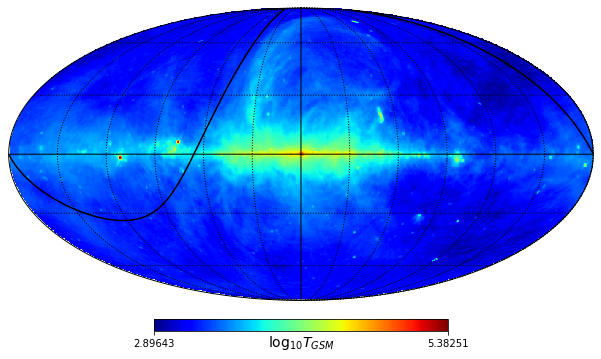

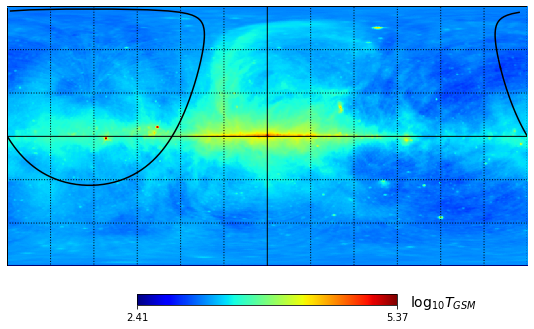

In [12]:
# Data of the GSM model for 70 MHz.
Data_70 = pd.read_hdf("gsm_maps/gsm_70MHz.hdf5")
bmap_gal = Data_70.values[:,0]
bmap_gal = np.log10(bmap_gal)

#Mollweide visualization
hp.mollview(bmap_gal,cmap=Cmap, unit = r'$\log_{10}T_{GSM}$',title='')
hp.projplot(l_gal, b_gal,'-k',lonlat=True) #Projects the trajectory.
hp.graticule()
#plt.savefig(impath+'Trajectory_mollview.png')
plt.show()

#Cartesian visualization
hp.cartview(bmap_gal,cmap=Cmap, unit = r'$\log_{10}T_{GSM}$',title='')
hp.projplot(l_gal, b_gal,'-k',lonlat=True)
hp.graticule()
#plt.savefig(impath+'Trajectory_cartview.png')
plt.show()

# Beam Pattern

In this part of the notebook we will generate the beam pattern of the antenna for diferent times, in order to see how the pattern moves along the sky in function of time. Also the trajectory is projected to check if the center of the pattern coincides with the trajectory.

For this we will use the pattern function in Tgsm.py

2013-06-14 00:00:00.000


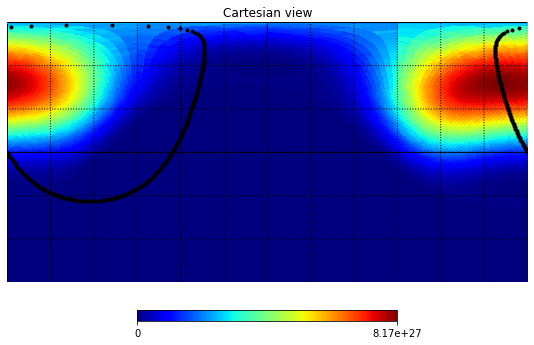

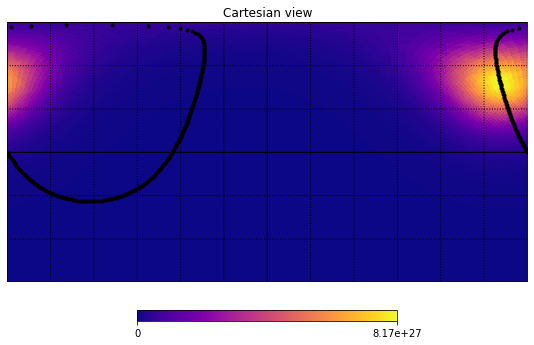

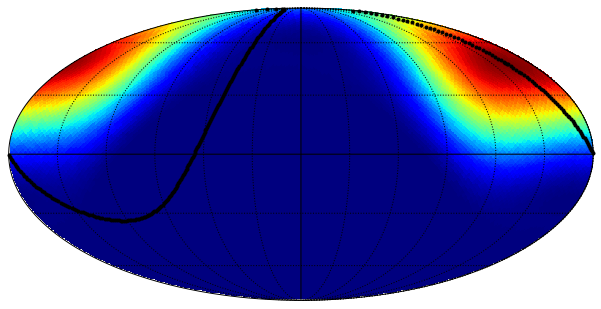

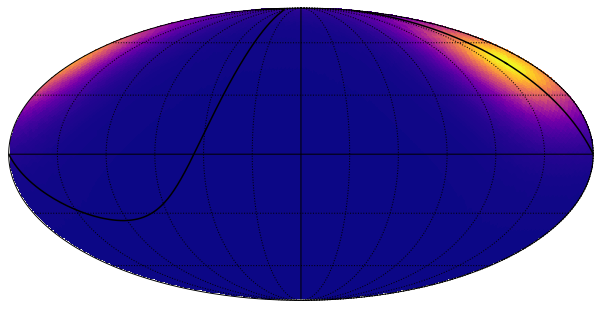

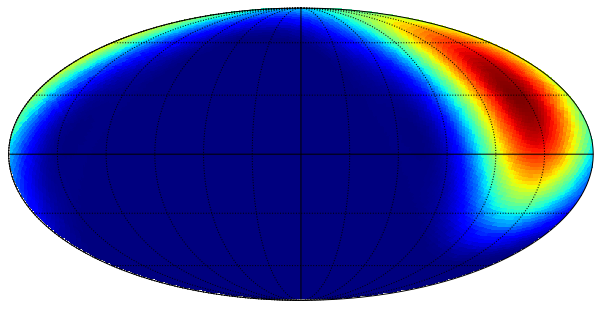

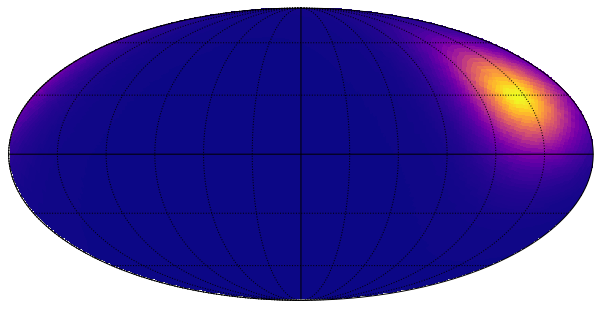

2013-06-14 04:00:00.000


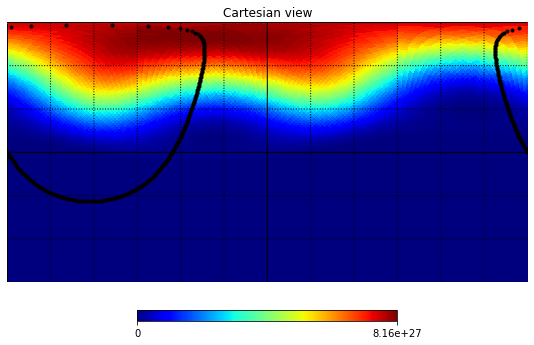

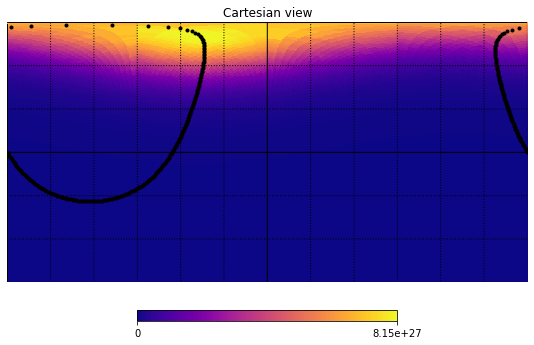

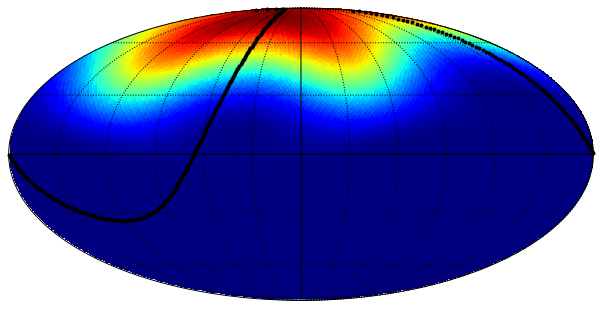

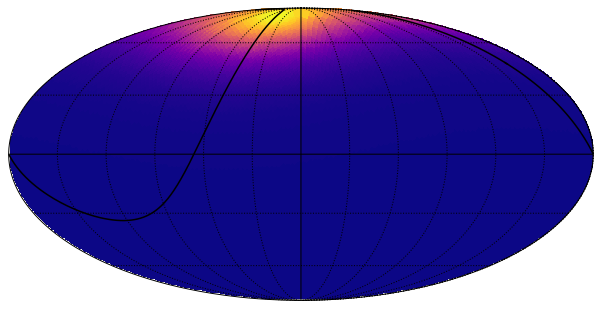

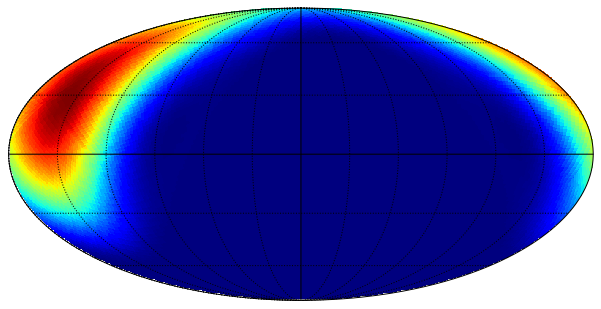

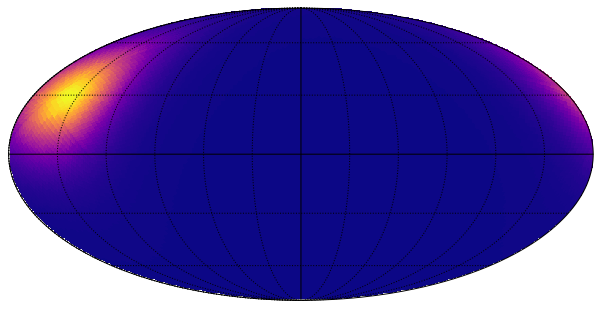

2013-06-14 08:00:00.000


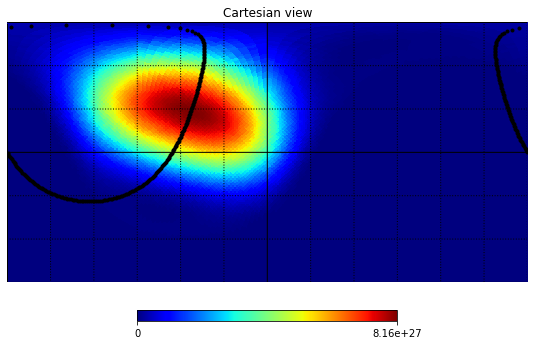

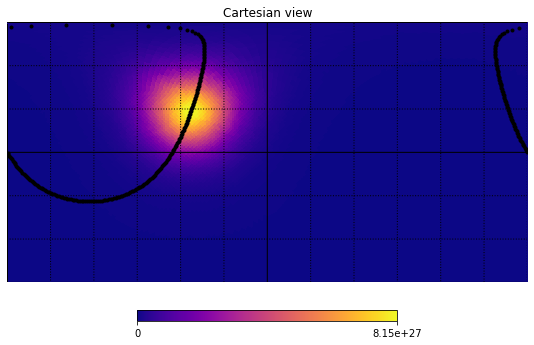

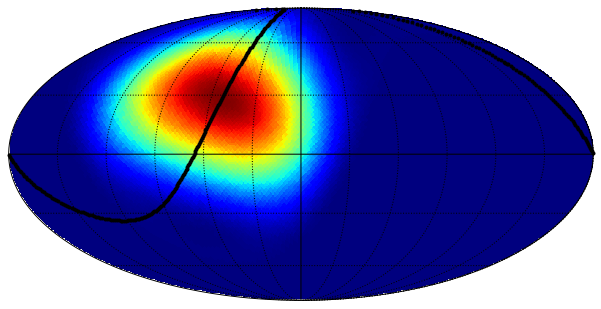

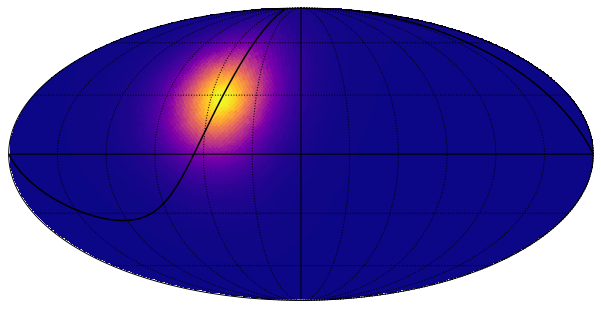

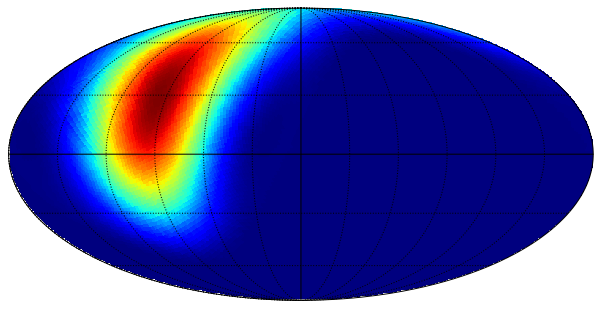

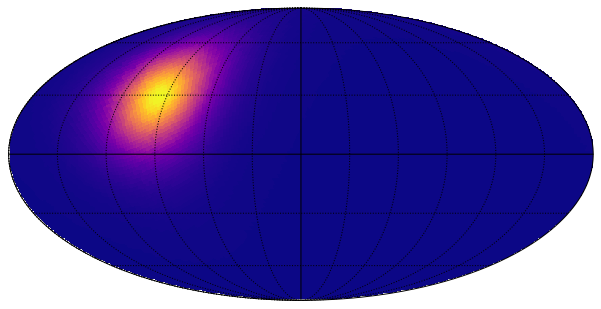

2013-06-14 12:00:00.000


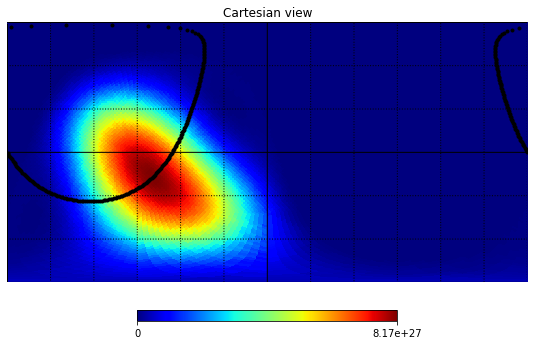

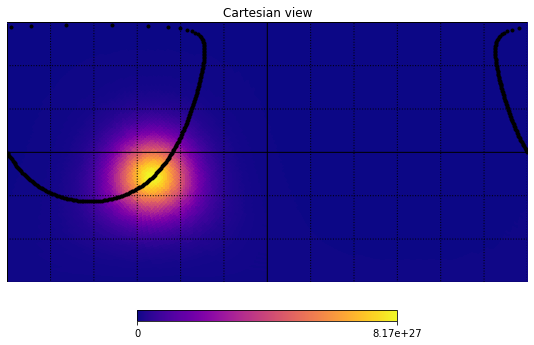

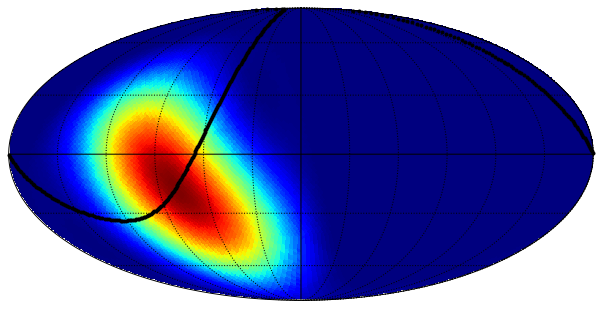

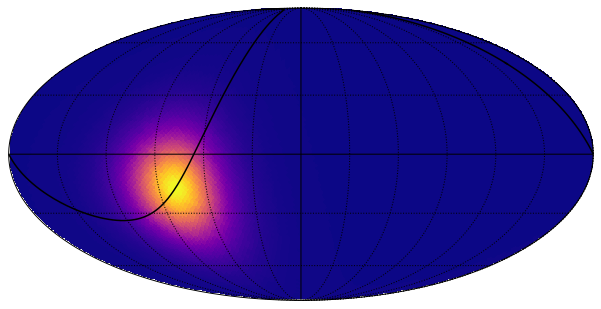

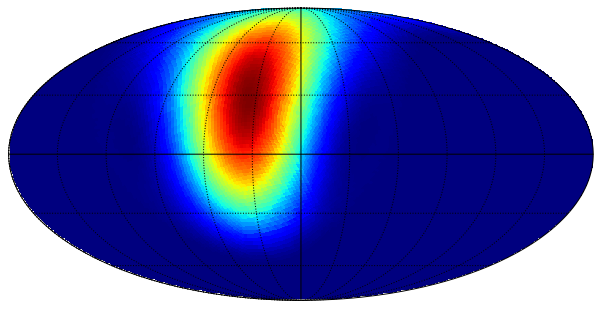

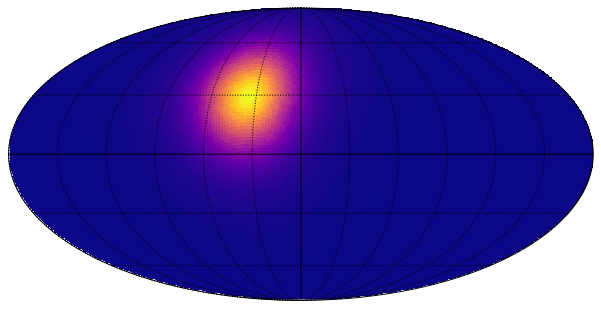

2013-06-14 16:00:00.000


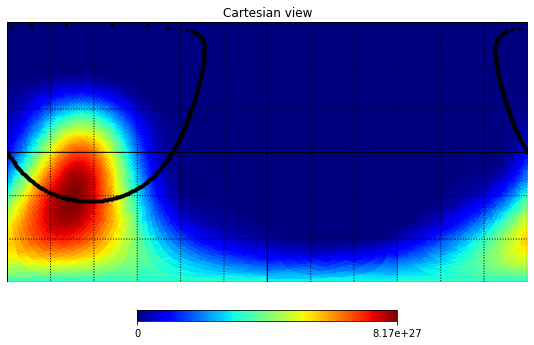

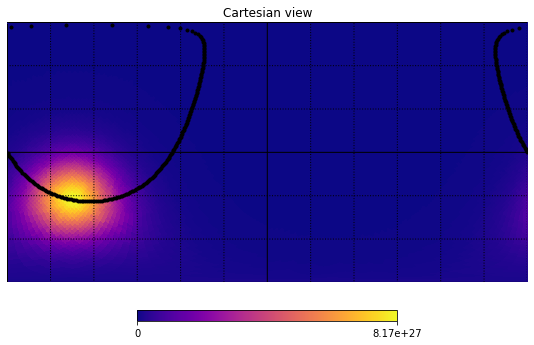

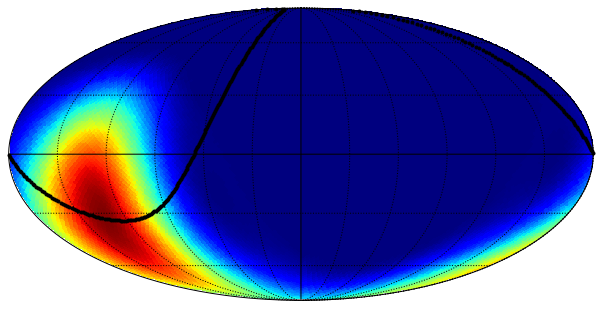

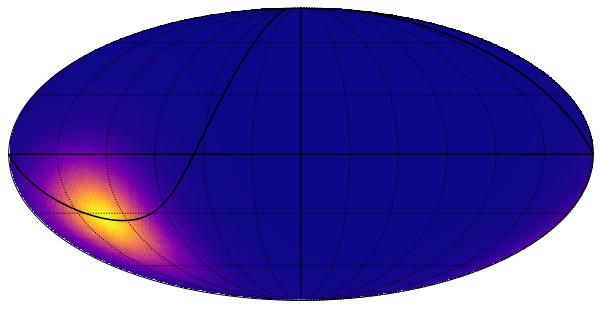

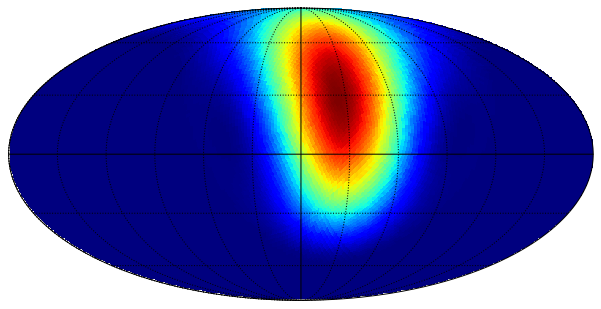

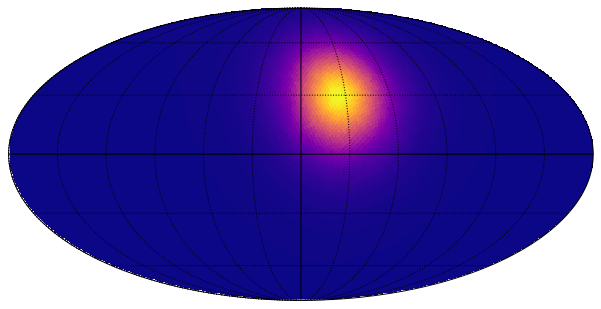

2013-06-14 20:00:00.000


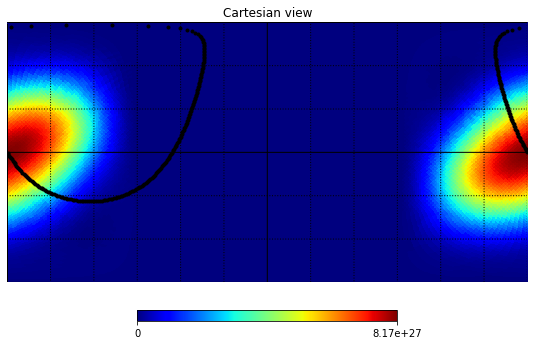

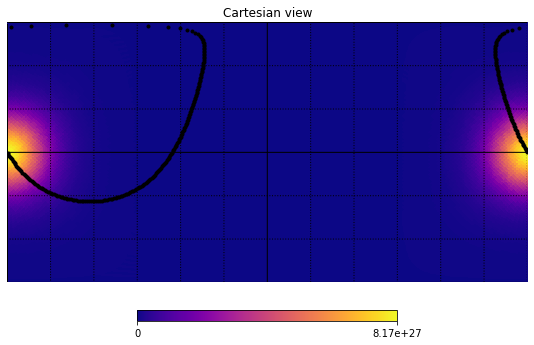

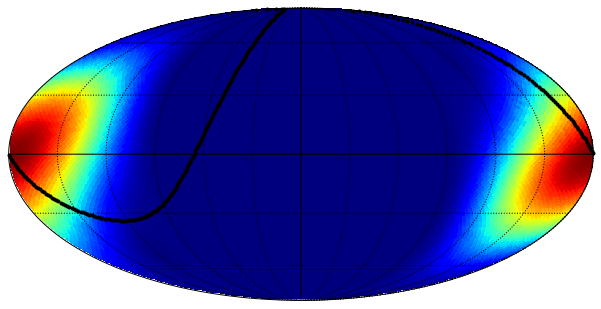

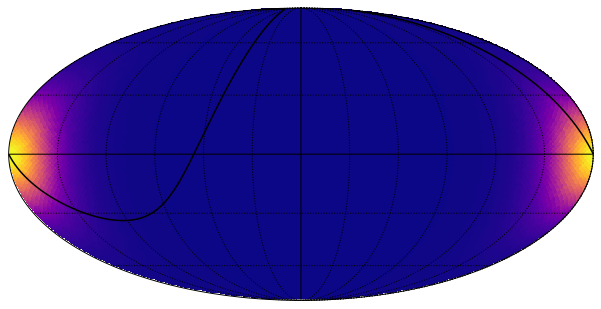

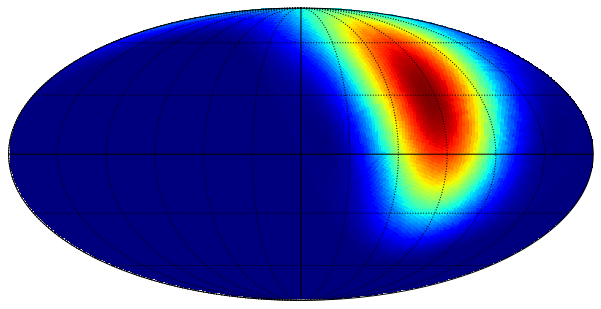

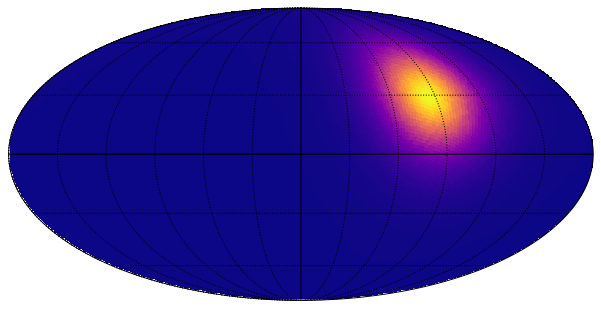

In [13]:
t0 = Time('2013-06-14 00:00:00')
dt = 4*u.hour
times = t0 + dt*np.arange(0,24/dt.value)
for i in range(len(times)):
    print (times[i])
    # Getting the pattern 
    l,b,Temp = pattern(time = times[i],Freq=70)
    l_mock,b_mock,Temp_mock = pattern(time = times[i],Freq=70,PATH='mock_pattern/')
    
    # Projecting the pattern into pixels.
    nside = 32
    pix = hp.ang2pix(nside,l, b, lonlat=True)
    pix_mock = hp.ang2pix(nside,l_mock, b_mock, lonlat=True)
    
    # Filling the pixels with the temperature data.
    bmap_pat = np.zeros(hp.nside2npix(nside))
    bmap_pat[pix] = Temp
    bmap_pat_mock = np.zeros(hp.nside2npix(nside))
    bmap_pat_mock[pix] = Temp_mock
    
    # Cartesian visualization.
    hp.cartview(bmap_pat,cmap=Cmap)
    hp.projplot(l_gal, b_gal,'.k',lonlat=True)
    hp.graticule()
    hp.cartview(bmap_pat_mock,cmap=Cmap_mock)
    hp.projplot(l_gal, b_gal,'.k',lonlat=True)
    hp.graticule()
    #plt.savefig('Imagenes/'+str(t0+i*dt)+'_cartview_gal.png')
    plt.show()
    
    #Mollweide visualization 
    hp.mollview(bmap_pat,cmap=Cmap,cbar=False,title='')
    hp.projplot(l_gal, b_gal,'.k',lonlat=True)
    hp.graticule()
    hp.mollview(bmap_pat_mock,cmap=Cmap_mock,cbar=False,title='')
    hp.projplot(l_gal, b_gal,'-k',lonlat=True)
    hp.graticule()
    #plt.savefig(impath+str(t0+i*dt)+'_mollview_gal.png')
    plt.show()
    
    # Made for comparing with SCI-HI paper.
    hp.mollview(bmap_pat,coord =['G','C'],cmap=Cmap,flip='geo',cbar=False,title='',notext=True)
    hp.graticule()
    hp.mollview(bmap_pat_mock,coord =['G','C'],cmap=Cmap_mock,flip='geo',cbar=False,title='',notext=True)
    hp.graticule()
    #plt.savefig(impath+str(t0+i*dt)+'_mollview_altaz.png')
    plt.show()

# Generate Simulated Data (Convolution)

This part of the notebook generates an HDF5 table with the convolved temperatures of the antenna for a day of observation, the binnage in this case is 5 minutes, it can be changed by modifying the bins parameter.

The function to use is T_gsm from Tgsm.py. 

Uncomment if needed.

In [7]:
#T_gsm('2013-06-14 00:00:00',PATH='mock_pattern/',OUTPUT='mock/') # You can change the path to anywhere your antenna beam pattern files are.
#T_gsm('2013-06-14 00:00:00') 

# Diurnal Variation and Simulated Temperature

Checking the diurnal variation of the temperature for every frequency in the rage 50-90 MHz.

In [8]:
# Data generated in the convolution.
Data = pd.read_hdf('calibration/Tgsm.hdf5')
Data_mock = pd.read_hdf('mock/Tgsm.hdf5')
Freqs = np.arange(50,91)

Checking the Local Sidereal Time (LST) for the date, this is done in order to plot the diurnal variation of a given frequency in functiong of LST, this could be done in function of UTC, but for comparision with SCI-HI paper.

In [9]:
check_LST('2013-06-14 00:00:00')

LST time: 9h36m36.5988s


<Longitude 9.61016633 hourangle>

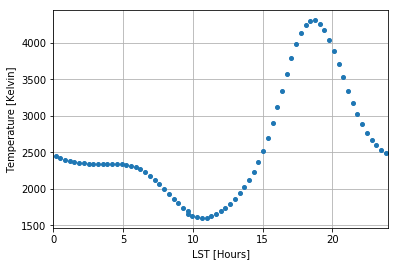

In [10]:
f=70 #Frequency to check
Temp = Data.loc[f].values
Temp_mock = Data_mock.loc[f].values
Time_ = (np.linspace(0,24,len(Temp))+9.62)%24 # For 2013-06-14 LST = UTC + 9:37 (9.62h)
plt.plot(Time_,Temp,'o',markersize = 4,label='HIbiscus')
#plt.plot(Time_,Temp_mock,'ro',markersize = 4,label='Gaussian')
plt.xlabel('LST [Hours]')
plt.ylabel('Temperature [Kelvin]')
plt.xlim(0,24)
plt.grid()
#plt.legend()
plt.savefig(impath+'variation_%dMHz.png'%f)

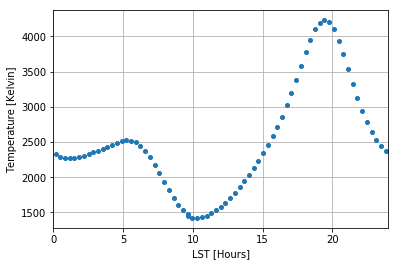

In [11]:
f=70 #Frequency to check
Temp = Data.loc[f].values
Temp_mock = Data_mock.loc[f].values
Time_ = (np.linspace(0,24,len(Temp))+9.62)%24 # For 2013-06-14 LST = UTC + 9:37 (9.62h)
#plt.plot(Time_,Temp,'o',markersize = 4,label='HIbiscus')
plt.plot(Time_,Temp_mock,'o',markersize = 4,label='Gaussian')
plt.xlabel('LST [Hours]')
plt.ylabel('Temperature [Kelvin]')
plt.xlim(0,24)
plt.grid()
#plt.legend()
plt.savefig(impath+'mockvariation_%dMHz.png'%f)

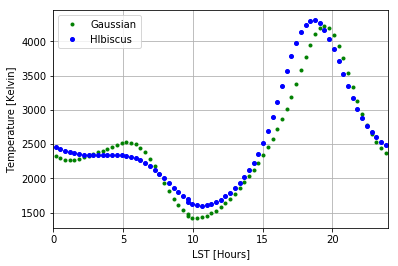

In [12]:
f=70 #Frequency to check
Temp = Data.loc[f].values
Temp_mock = Data_mock.loc[f].values
Time_ = (np.linspace(0,24,len(Temp))+9.62)%24 # For 2013-06-14 LST = UTC + 9:37 (9.62h)
plt.plot(Time_,Temp_mock,'go',markersize = 3,label='Gaussian')
plt.plot(Time_,Temp,'bo',markersize = 4,label='HIbiscus')
plt.xlabel('LST [Hours]')
plt.ylabel('Temperature [Kelvin]')
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.savefig(impath+'variation_%dMHz.png'%f)

Plotting the diurnal variation for every frequency in the range of 50-90 MHz.

Note: No conversion to LST has be done in this part, so the plot's xlabel is in UTC.

In [13]:
for f in Freqs:
    Temp = Data.loc[f].values
    Time_ = np.linspace(0,24,len(Temp))
    plt.plot(Time_[::5],Temp[::5],'-o',markersize = 4)
    plt.xlabel('UTC [Hours]')
    plt.ylabel('Temperature [Kelvin]')
    plt.xlim(0,24)
    plt.grid()
    plt.savefig('Imagenes/mockvariation_%dMHz.png'%f)
    plt.close()

Plotting the temperature in function of the frequency for the date given.

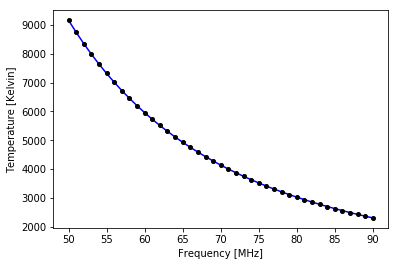

In [14]:
Temp = Data['2013-06-14 08:00:00.000'].values
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.plot(Freqs,Temp,'-b')
plt.plot(Freqs,Temp,'ko', markersize=4)
#plt.xlim(60,90)
#plt.ylim(1900,6500)
plt.savefig(impath+'FreqvsTemp.png')
plt.show()

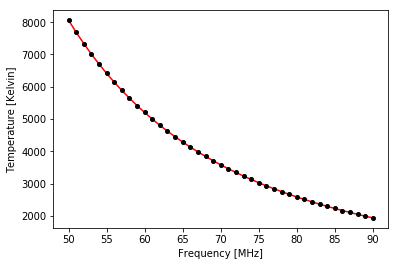

In [15]:
Temp = Data_mock['2013-06-14 08:00:00.000'].values
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.plot(Freqs,Temp,'-r')
plt.plot(Freqs,Temp,'ko', markersize=4)
#plt.xlim(60,90)
#plt.ylim(1900,6500)
plt.savefig(impath+'mockFreqvsTemp.png')
plt.show()

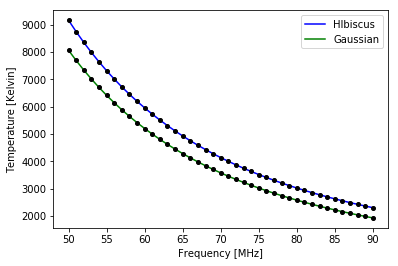

In [16]:
Temp = Data['2013-06-14 08:00:00.000'].values
Temp_mock = Data_mock['2013-06-14 08:00:00.000'].values
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.plot(Freqs,Temp,'-b',label='HIbiscus')
plt.plot(Freqs,Temp,'ko', markersize=4)
plt.plot(Freqs,Temp_mock,'-g',label='Gaussian')
plt.plot(Freqs,Temp_mock,'ko', markersize=4)
#plt.xlim(60,90)
#plt.ylim(1900,6500)
plt.legend()
plt.savefig(impath+'FreqvsTemp.png')
plt.show()

In [22]:
Data['2013-06-14 16:00:00.000']-Data_mock['2013-06-14 16:00:00.000']

50    150.053857
51    143.381637
52    137.123622
53    131.244993
54    125.717038
55    120.512016
56    115.605151
57    110.974794
58    106.599279
59    102.461054
60     98.543786
61     94.831079
62     91.308445
63     87.962702
64     84.783078
65     81.757335
66     78.876251
67     76.129488
68     73.508379
69     71.005352
70     68.612703
71     66.323425
72     64.130728
73     62.028369
74     60.011289
75     58.073650
76     56.210345
77     54.417171
78     52.689259
79     51.022814
80     49.413208
81     47.857518
82     46.351473
83     44.892383
84     43.476445
85     42.101019
86     40.762926
87     39.459506
88     38.188277
89     36.946615
90     35.731927
Name: 2013-06-14 16:00:00.000, dtype: float64

In [23]:
Data['2013-06-14 08:00:00.000']-Data_mock['2013-06-14 08:00:00.000']

50    1097.119119
51    1052.547451
52    1010.746042
53     971.501575
54     934.612610
55     899.907348
56     867.220499
57     836.411347
58     807.342687
59     779.894816
60     753.958629
61     729.432597
62     706.224092
63     684.252114
64     663.433847
65     643.700319
66     624.984973
67     607.229755
68     590.376158
69     574.373500
70     559.173896
71     544.733248
72     531.011563
73     517.968781
74     505.571530
75     493.786323
76     482.583436
77     471.931471
78     461.807818
79     452.184899
80     443.040642
81     434.351681
82     426.100622
83     418.265219
84     410.828809
85     403.774635
86     397.085592
87     390.746994
88     384.744188
89     379.064062
90     373.693255
Name: 2013-06-14 08:00:00.000, dtype: float64